# Dog breed App prediction: Random Forests

In [1]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline


## Loading and Preprocessing Loans Encoded Data

In [2]:
# Loading data
file_path = Path("../sourcedata/akc_dog_breed_cln.csv")
dog_breed_val_df = pd.read_csv(file_path)
dog_breed_val_df.head()

,breed,description,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,...,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category,akc_breed,kaggle_breed,Img_Link,group_values
0,Affenpinscher,The Affen’s apish look has been described many...,"Confident, Famously Funny, Fearless",148,10,12,7,12,12,15,...,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing,affenpinscher,affenpinscher,https://www.akc.org/wp-content/uploads/2017/11...,0
1,Afghan Hound,"The Afghan Hound is an ancient breed, his whol...","Dignified, Profoundly Loyal, Aristocratic",113,25,27,50,60,12,15,...,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary,afghan_hound,afghan_hound,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,1
2,Airedale Terrier,The Airedale Terrier is the largest of all ter...,"Friendly, Clever, Courageous",60,21,23,44,50,11,14,...,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly,airedale_terrier,airedale,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,2
3,Akita,"Akitas are burly, heavy-boned spitz-type dogs ...","Courageous, Dignified, Profoundly Loyal",47,24,28,70,130,10,13,...,0.8,Energetic,1.0,Eager to Please,0.6,Alert/Responsive,akita,NaN,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,3
4,Alaskan Malamute,The Alaskan Malamute stands 23 to 25 inches at...,"Affectionate, Loyal, Playful",58,23,25,75,85,10,14,...,0.8,Energetic,0.4,Independent,0.8,Friendly,alaskan_malamute,malamute,https://s3.amazonaws.com/cdn-origin-etr.akc.or...,3


In [3]:
dog_breed_val_df.columns

Index(['breed', 'description', 'temperament', 'popularity', 'min_height',
       'max_height', 'min_weight', 'max_weight', 'min_expectancy',
       'max_expectancy', 'group', 'grooming_frequency_value',
       'grooming_frequency_category', 'shedding_value', 'shedding_category',
       'energy_level_value', 'energy_level_category', 'trainability_value',
       'trainability_category', 'demeanor_value', 'demeanor_category',
       'akc_breed', 'kaggle_breed', 'Img_Link', 'group_values'],
      dtype='object')

In [4]:
dog_breed_new_df = [dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df,dog_breed_val_df]
dog_breed_data_df = pd.concat(dog_breed_new_df)
dog_breed_data_df = dog_breed_data_df.sample(frac = 100,replace=True).reset_index(drop=True)
dog_breed_data_df.shape

(304700, 25)

In [5]:
dog_breed_data_df['group'].value_counts()

Foundation Stock Service    74758
Sporting Group              35567
Hound Group                 35186
Terrier Group               33960
Working Group               33944
Herding Group               33153
Non-Sporting Group          23144
Toy Group                   22878
Miscellaneous Class         12110
Name: group, dtype: int64

In [6]:
# Define features set
# cat_col = ['grooming_frequency_category','shedding_category', 'energy_level_category', 'trainability_category', 'demeanor_category']
# val_col = ['grooming_frequency_value', 'shedding_value', 'energy_level_value', 'trainability_value', 'demeanor_value']
col_to_drop = ['breed','group','description','grooming_frequency_category','shedding_category', 
                'energy_level_category', 'trainability_category', 'demeanor_category', 'temperament',
                'akc_breed', 'kaggle_breed', 'Img_Link', 'group_values']
X = dog_breed_val_df.copy()
X.drop(col_to_drop, axis=1, inplace=True)
X.head()

,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,grooming_frequency_value,shedding_value,energy_level_value,trainability_value,demeanor_value
0,148,10,12,7,12,12,15,0.6,0.6,0.6,0.8,1.0
1,113,25,27,50,60,12,15,0.8,0.2,0.8,0.2,0.2
2,60,21,23,44,50,11,14,0.6,0.4,0.6,1.0,0.8
3,47,24,28,70,130,10,13,0.8,0.6,0.8,1.0,0.6
4,58,23,25,75,85,10,14,0.6,0.6,0.8,0.4,0.8


In [7]:
# Define target vector
# The ravel() function is a method provided by NumPy (a popular numerical computing library for Python). 
# It's used to flatten a multi-dimensional array (or matrix) into a one-dimensional array. 

y = dog_breed_val_df['group_values'].ravel()
y

array([0, 1, 2, 3, 3, 4, 1, 5, 1, 2, 4, 2, 6, 3, 4, 7, 4, 7, 4, 2, 1, 6,
       1, 4, 1, 4, 1, 7, 7, 2, 8, 7, 7, 7, 7, 7, 3, 5, 8, 1, 3, 1, 1, 3,
       4, 4, 7, 2, 1, 5, 7, 3, 6, 8, 4, 4, 7, 6, 4, 0, 2, 5, 3, 2, 7, 3,
       7, 4, 4, 4, 0, 4, 2, 6, 0, 0, 5, 3, 5, 1, 6, 6, 7, 5, 4, 6, 4, 1,
       5, 2, 4, 4, 3, 3, 3, 4, 4, 8, 6, 1, 6, 6, 0, 7, 4, 4, 6, 7, 5, 6,
       5, 4, 4, 3, 7, 6, 4, 6, 3, 2, 6, 6, 1, 3, 3, 3, 1, 4, 4, 1, 0, 4,
       4, 1, 7, 6, 6, 2, 6, 1, 0, 4, 0, 4, 4, 4, 4, 5, 2, 4, 3, 4, 3, 6,
       6, 2, 8, 4, 3, 5, 5, 0, 2, 0, 3, 7, 2, 0, 2, 4, 8, 3, 6, 3, 2, 8,
       7, 1, 5, 2, 6, 7, 1, 0, 2, 0, 7, 4, 8, 1, 1, 1, 6, 7, 0, 5, 5, 0,
       4, 8, 1, 4, 4, 3, 4, 0, 7, 7, 4, 7, 4, 2, 1, 1, 4, 3, 2, 8, 4, 3,
       1, 3, 4, 5, 1, 2, 2, 4, 7, 5, 0, 4, 3, 0, 2, 1, 4, 4, 4, 4, 2, 2,
       4, 7, 6, 4, 2, 3, 6, 4, 7, 4, 8, 4, 3, 5, 5, 4, 4, 0, 4, 4, 1, 6,
       6, 6, 2, 2, 4, 1, 2, 6, 6, 4, 5, 4, 0], dtype=int64)

In [8]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [9]:
from imblearn.over_sampling import SMOTE
# Apply SMOTE to balance the class distribution
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [10]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [11]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train_resampled)

In [12]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train_resampled)
X_test_scaled = X_scaler.transform(X_test)

## Fitting the Random Forest Model

In [13]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [14]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train_resampled)

## Making Predictions Using the Random Forest Model

In [15]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

## Model Evaluation

In [16]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm)

#     cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
# )

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [17]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,0,1,2,3,4,5,6,7,8
0,3,0,1,0,0,0,0,0,0
1,2,2,2,0,0,0,1,0,0
2,0,0,6,0,0,3,1,0,0
3,0,1,0,3,0,0,1,0,0
4,0,0,0,0,18,0,0,0,3
5,0,0,2,0,0,2,2,1,0
6,0,0,0,0,1,0,3,1,0
7,0,6,1,0,0,1,1,1,0
8,0,0,0,0,0,0,0,0,1


Accuracy Score : 0.5571428571428572
Classification Report
              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.22      0.29      0.25         7
           2       0.50      0.60      0.55        10
           3       1.00      0.60      0.75         5
           4       0.95      0.86      0.90        21
           5       0.33      0.29      0.31         7
           6       0.33      0.60      0.43         5
           7       0.33      0.10      0.15        10
           8       0.25      1.00      0.40         1

    accuracy                           0.56        70
   macro avg       0.50      0.56      0.49        70
weighted avg       0.59      0.56      0.55        70



## Feature Importance

In [18]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.17706532220414545, 'popularity'),
 (0.13807286629019877, 'max_weight'),
 (0.1079050705021984, 'min_weight'),
 (0.08847223928222599, 'max_height'),
 (0.08782159144359787, 'trainability_value'),
 (0.07860293120404209, 'min_height'),
 (0.06972910015623592, 'energy_level_value'),
 (0.06135688201729197, 'demeanor_value'),
 (0.06129816284892202, 'shedding_value'),
 (0.04787736458820016, 'grooming_frequency_value'),
 (0.04711013969301956, 'min_expectancy'),
 (0.03468832976992181, 'max_expectancy')]

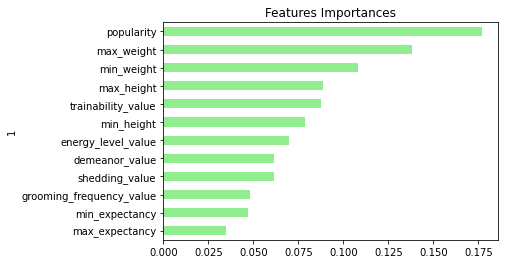

In [19]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [20]:
# Extract the data from the Series and convert it to a numpy array
user_val = 100
user_input = []
user_input = X.iloc[user_val].values


# # Reshape the user_input to a 2-dimensional array
user_input_reshaped = user_input.reshape(1, -1)

# # Now user_input_reshaped is a 2D array
print((user_input_reshaped))

[[94.  24.  25.  50.  70.  12.  12.   0.6  0.8  0.8  0.8  0.8]]


In [21]:
new_predictions = rf_model.predict(user_input_reshaped)
print(new_predictions)
print(y[new_predictions])

[3]
[3]


In [22]:
print(dog_breed_val_df[['group','group_values','popularity']].iloc[user_val])

group           Sporting Group
group_values                 6
popularity                  94
Name: 100, dtype: object


In [25]:
# Save Model Using Pickle

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import pickle

# save the model to disk
filename = 'dog_app_rf_group_pred_smote.sav'
pickle.dump(rf_model, open(filename, 'wb'))

# some time later...

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test_scaled, y_test)
print(result)

0.5571428571428572
